<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W3D1_RealNeurons/W3D1_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 3, Day 1, Tutorial 1
# Real Neurons: The Leaky Integrate-and-Fire (LIF) Neuron Model
__Content creators:__ Qinglong Gu, Songtin Li, John Murray, Richard Naud, Arvind Kumar

__Content reviewers:__ Spiros Chavlis, Lorenzo Fontolan, Richard Gao, Matthew Krause

---
# Tutorial Objectives
This is Tutorial 1 of a series on implementing realistic neuron models. In this tutorial, we will build up a leaky integrate-and-fire (LIF) neuron model and study its dynamics in response to various types of inputs. In particular, we are going to write a few lines of code to:  

- simulate the LIF neuron model

- drive the LIF neuron with external inputs, such as DC current, Gaussian white noise, and Poisson spike trains, etc.

- study how different inputs affect the  LIF neuron's output (firing rate and spike time irregularity)

Here, we will especially emphasize identifying conditions (input statistics) under which a neuron can spike at low firing rates and in an irregular manner. The reason for focusing on this is that in most cases, neocortical neurons spike in an irregular manner.

---
# Setup

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# @title Figure Settings
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
my_layout = widgets.Layout()

In [3]:
# @title Helper functions


def plot_volt_trace(pars, v, sp):
  """
  Plot trajetory of membrane potential for a single neuron

  Expects:
  pars   : parameter dictionary
  v      : volt trajetory
  sp     : spike train

  Returns:
  figure of the membrane potential trajetory for a single neuron
  """

  V_th = pars['V_th']
  dt, range_t = pars['dt'], pars['range_t']
  if sp.size:
    sp_num = (sp / dt).astype(int) - 1
    v[sp_num] += 20  # draw nicer spikes

  plt.plot(pars['range_t'], v, 'b')
  plt.axhline(V_th, 0, 1, color='k', ls='--')
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)')
  plt.legend(['Membrane\npotential', r'Threshold V$_{\mathrm{th}}$'],
             loc=[1.05, 0.75])
  plt.ylim([-80, -40])


def plot_GWN(pars, I_GWN):
  """
  Args:
    pars  : parameter dictionary
    I_GWN : Gaussian white noise input

  Returns:
    figure of the gaussian white noise input
  """

  plt.figure(figsize=(12, 4))
  plt.subplot(121)
  plt.plot(pars['range_t'][::3], I_GWN[::3], 'b')
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$I_{GWN}$ (pA)')
  plt.subplot(122)
  plot_volt_trace(pars, v, sp)
  plt.tight_layout()


def my_hists(isi1, isi2, cv1, cv2, sigma1, sigma2):
  """
  Args:
    isi1 : vector with inter-spike intervals
    isi2 : vector with inter-spike intervals
    cv1  : coefficient of variation for isi1
    cv2  : coefficient of variation for isi2

  Returns:
    figure with two histograms, isi1, isi2

  """
  plt.figure(figsize=(11, 4))
  my_bins = np.linspace(10, 30, 20)
  plt.subplot(121)
  plt.hist(isi1, bins=my_bins, color='b', alpha=0.5)
  plt.xlabel('ISI (ms)')
  plt.ylabel('count')
  plt.title(r'$\sigma_{GWN}=$%.1f, CV$_{\mathrm{isi}}$=%.3f' % (sigma1, cv1))

  plt.subplot(122)
  plt.hist(isi2, bins=my_bins, color='b', alpha=0.5)
  plt.xlabel('ISI (ms)')
  plt.ylabel('count')
  plt.title(r'$\sigma_{GWN}=$%.1f, CV$_{\mathrm{isi}}$=%.3f' % (sigma2, cv2))
  plt.tight_layout()
  plt.show()

---
# Section 1: The Leaky Integrate-and-Fire (LIF) model

Video available at https://youtube.com/watch?v=rSExvwCVRYg


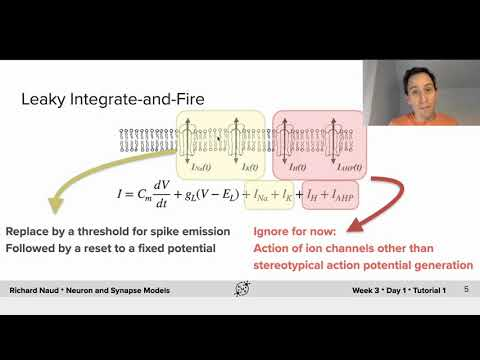

In [4]:
#@title Video 1: Reduced Neuron Models
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='rSExvwCVRYg', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Implementation of an LIF neuron model

Now, it's your turn to implement one of the simplest mathematical model of a neuron: the leaky integrate-and-fire (LIF) model. The basic idea of LIF neuron was proposed in 1907 by Louis Édouard Lapicque, long before we understood the electrophysiology of a neuron (see a translation of [Lapicque's paper](https://pubmed.ncbi.nlm.nih.gov/17968583/) ). More details of the model can be found in the book [**Theoretical neuroscience**](http://www.gatsby.ucl.ac.uk/~dayan/book/) by Peter Dayan and Laurence F. Abbott.

The subthreshold membrane potential dynamics of a LIF neuron is described by

\begin{eqnarray}
C_m\frac{dV}{dt} = -g_L(V-E_L) + I,\quad (1)
\end{eqnarray}

where $C_m$ is the membrane capacitance, $V$ is the membrane potential, $g_L$ is the leak conductance ($g_L = 1/R$, the inverse of the leak resistance $R$ mentioned in previous tutorials), $E_L$ is the resting potential, and $I$ is the external input current. 

Dividing both sides of the above equation by $g_L$ gives

\begin{align}
\tau_m\frac{dV}{dt} = -(V-E_L) + \frac{I}{g_L}\,,\quad (2)
\end{align}

where the $\tau_m$ is membrane time constant and is defined as $\tau_m=C_m/g_L$. 

You might wonder how come dividing capacitance by conductance gives units of time! Find out yourself why it is so.

Below we will use Eqn.(1) to simulate the LIF neuron dynamics. 

If $I$ is sufficiently strong such that $V$ reaches a certain threshold value $V_{\rm th}$, $V$ is reset to a reset potential $V_{\rm reset}< V_{\rm th}$ and voltage is clamped to $V_{\rm reset}$ for $\tau_{\rm ref}$ ms mimicking the refractoriness of the neuron during an action potential, _i.e._,

\begin{eqnarray}
\mathrm{if}\quad V(t_{\text{sp}})\geq V_{\rm th}&:& V(t)=V_{\rm reset} \text{  for } t\in(t_{\text{sp}}, t_{\text{sp}} + \tau_{\text{ref}}]
\end{eqnarray}
where $t_{\rm sp}$ is the spike time when $V(t)$ just exceeded $V_{\rm th}$.

(__Note__: in the lecture slides, $\theta$ corresponds to the threshold voltage $V_{th}$, and $\Delta$ corresponds to the refractory time $\tau_{\rm ref}$.)

Thus, the LIF model captures the facts that a neuron:
- performs spatial and temporal integration of synaptic inputs 
- generates a spike when the voltage reaches a certain threshold
- goes refractory during the action potential
- membrane is leaky

The LIF model assumes that spatial and temporal integration of inputs is linear. Also, membrane potential dynamics close to the spike threshold is much slower in LIF neurons than in real neurons. 


## Exercise 1: Python code to simulate the LIF neuron

We now **write** Python code to calculate Eqn. (2) and simulate the LIF neuron dynamics.

The cell below initializes a dictionary that stores parameters of the LIF neuron model and the simulation scheme. You can use `pars=default_pars(T=simulation_time, dt=time_step)` to get the parameters (you can try to print the dictionary `pars`). Note that, `simulation_time` and `time_step` have the unit `ms`. In addition, you can add the value to a new parameter by `pars['New_param'] = value`.

In [5]:
# @title

# @markdown Execute this code to initialize the default parameters


def default_pars(**kwargs):
  pars = {}

  # typical neuron parameters#
  pars['V_th'] = -55.     # spike threshold [mV]
  pars['V_reset'] = -75.  # reset potential [mV]
  pars['tau_m'] = 10.     # membrane time constant [ms]
  pars['g_L'] = 10.       # leak conductance [nS]
  pars['V_init'] = -75.   # initial potential [mV]
  pars['E_L'] = -75.      # leak reversal potential [mV]
  pars['tref'] = 2.       # refractory time (ms)

  # simulation parameters #
  pars['T'] = 400.  # Total duration of simulation [ms]
  pars['dt'] = .1   # Simulation time step [ms]

  # external parameters if any #
  for k in kwargs:
    pars[k] = kwargs[k]

  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]

  return pars


pars = default_pars()

The cell below defines the function to simulate the LIF neuron when receiving external current inputs. You can use `v, sp = run_LIF(pars, Iinj)` to get the membrane potential (`v`) and spike train (`sp`) given the dictionary `pars` and input current `Iinj`.

In [6]:
def run_LIF(pars, Iinj, stop=False):
  """
  Simulate the LIF dynamics with external input current

  Args:
    pars       : parameter dictionary
    Iinj       : input current [pA]. The injected current here can be a value
                 or an array
    stop       : boolean. If True, use a current pulse

  Returns:
    rec_v      : mebrane potential
    rec_sp     : spike times
  """

  # Set parameters
  V_th, V_reset = pars['V_th'], pars['V_reset']
  tau_m, g_L = pars['tau_m'], pars['g_L']
  V_init, E_L = pars['V_init'], pars['E_L']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tref = pars['tref']
  # Initialize voltage and current
  v = np.zeros(Lt)
  v[0] = V_init
  Iinj = Iinj * np.ones(Lt)
  if stop:
    Iinj[:int(len(Iinj) / 2) - 1000] = 0
    Iinj[int(len(Iinj) / 2) + 1000:] = 0
  tr = 0.  # the count for refractory duration
  # simulate the LIF dynamics
  rec_spikes = []  # record spike times
  for it in range(Lt - 1):
    if tr > 0:  # check for refractoriness
      v[it] = V_reset
      tr = tr - 1
    elif v[it] >= V_th:  # reset voltage and record spike event
      rec_spikes.append(it)
      v[it] = V_reset
      tr = tref / dt

    ########################################################################
    ## TODO for students: compute the membrane potential v, spike train sp #
    # Fill out function and remove
    raise NotImplementedError('Student Exercise: calculate the dv/dt and the update step!')
    ########################################################################
    # calculate the increment of the membrane potential
    dv = ...

    # update the membrane potential
    v[it+1] = ...

  rec_spikes = np.array(rec_spikes) * dt

  return v, rec_spikes


pars = default_pars(T=500)
# Uncomment below to test your function
# v, sp = run_LIF(pars, Iinj=100, stop=True)
# plot_volt_trace(pars, v, sp)
# plt.ylim([-80, -60])
# plt.show()

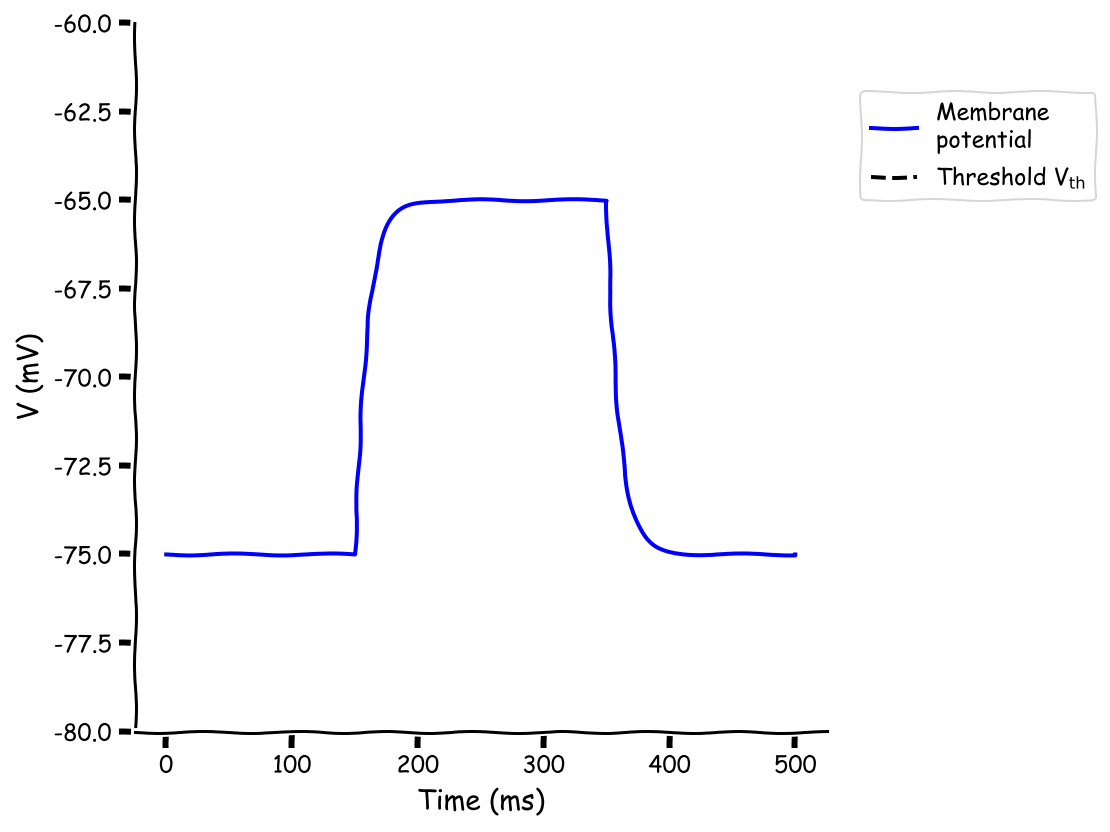

In [7]:
# to_remove solution
def run_LIF(pars, Iinj, stop=False):
  """
  Simulate the LIF dynamics with external input current

  Args:
    pars       : parameter dictionary
    Iinj       : input current [pA]. The injected current here can be a value
                 or an array
    stop       : boolean. If True, use a current pulse

  Returns:
    rec_v      : mebrane potential
    rec_sp     : spike times
  """
  # Set parameters
  V_th, V_reset = pars['V_th'], pars['V_reset']
  tau_m, g_L = pars['tau_m'], pars['g_L']
  V_init, E_L = pars['V_init'], pars['E_L']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tref = pars['tref']
  # Initialize voltage and current
  v = np.zeros(Lt)
  v[0] = V_init
  Iinj = Iinj * np.ones(Lt)
  if stop:
    Iinj[:int(len(Iinj) / 2) - 1000] = 0
    Iinj[int(len(Iinj) / 2) + 1000:] = 0
  tr = 0.  # the count for refractory duration
  # simulate the LIF dynamics
  rec_spikes = []  # record spike times
  for it in range(Lt - 1):
    if tr > 0:  # check for refractoriness
      v[it] = V_reset
      tr = tr - 1
    elif v[it] >= V_th:  # reset voltage and record spike event
      rec_spikes.append(it)
      v[it] = V_reset
      tr = tref / dt
    # calculate the increment of the membrane potential
    dv = (-(v[it] - E_L) + Iinj[it] / g_L) * (dt / tau_m)

    # update the membrane potential
    v[it+1] = v[it] + dv

  rec_spikes = np.array(rec_spikes) * dt

  return v, rec_spikes


pars = default_pars(T=500)
# Uncomment below to test your function
v, sp = run_LIF(pars, Iinj=100, stop=True)
with plt.xkcd():
  plot_volt_trace(pars, v, sp)
  plt.ylim([-80, -60])
  plt.show()

---
# Section 2: Response of an LIF model to different types of input currents
In the following section, we will learn how to inject direct current and white noise to study the response of an LIF neuron.

Video available at https://youtube.com/watch?v=preNGdab7Kk


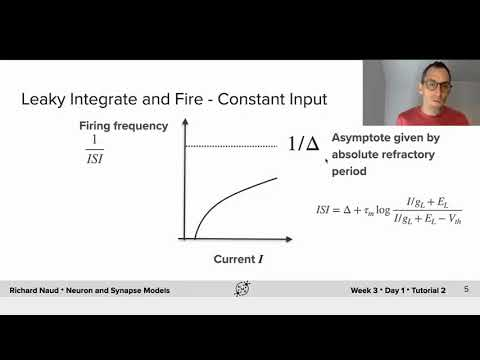

In [8]:
#@title Video 2: Response of the LIF neuron to different inputs
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='preNGdab7Kk', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Section 2.1: DC current

### LIF neuron driven by Constant current
Investigate the voltage response of the LIF neuron when receiving a DC current of 300 pA by `run_LIF` function.

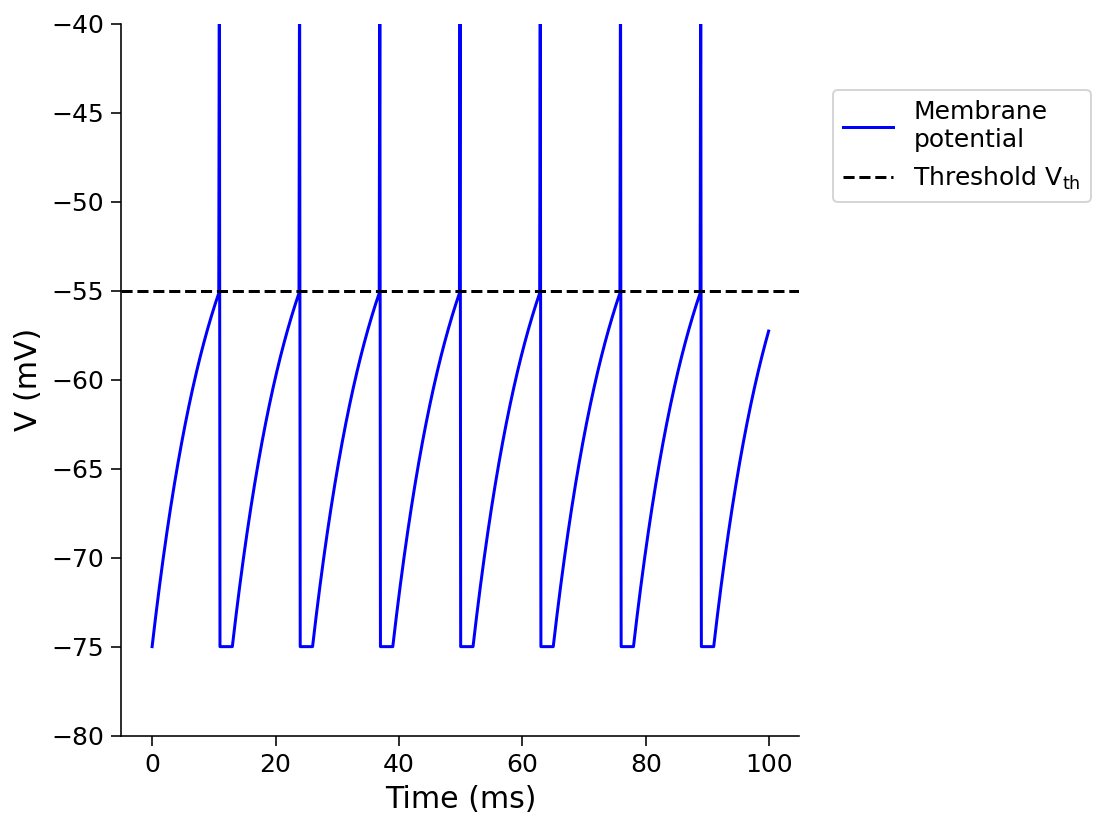

In [9]:
pars = default_pars(T=100)  # get the parameters
# Run the model to obtain v and sp
v, sp = run_LIF(pars, Iinj=300)

plot_volt_trace(pars, v, sp)
plt.show()

In the plot above, you see the membrane potential of an LIF neuron. You may notice that the neuron generates a spike. But this is just a cosmetic spike only for illustration purposes. In LIF neuron, we only need to keep track of times when the neuron hit the threshold so the postsynaptic neurons can be informed of the spike. 

### Interactive Demo: Parameter exploration of DC current amplitude 
Here's an interactive demo that shows how the LIF neuron behavior changes for DC input with different amplitudes.

**Remember to enable the demo by running the cell.**


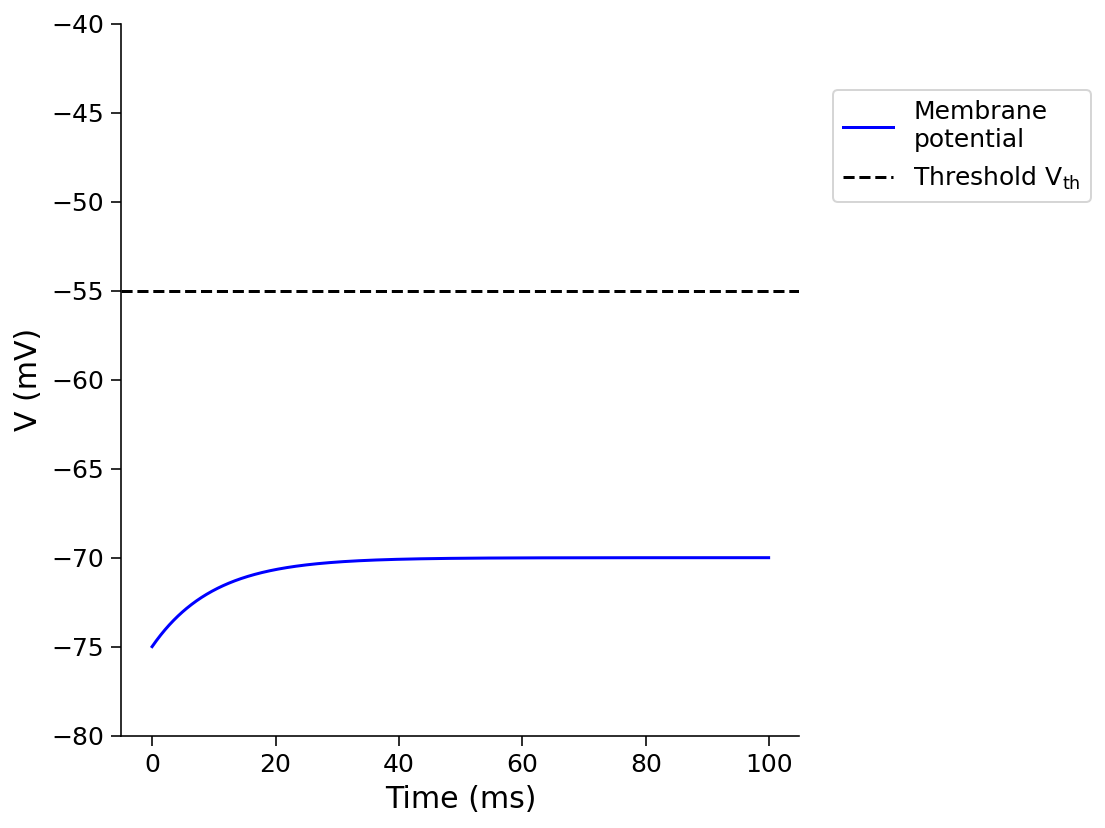

In [10]:
# @title
# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
    I_dc=widgets.FloatSlider(50., min=0., max=300., step=10.,
                               layout=my_layout),
    tau_m=widgets.FloatSlider(10., min=2., max=20., step=2.,
                                layout=my_layout)
)


def diff_DC(I_dc=200., tau_m=10.):
  pars = default_pars(T=100.)
  pars['tau_m'] = tau_m
  v, sp = run_LIF(pars, Iinj=I_dc)
  plot_volt_trace(pars, v, sp)
  plt.show()

## Section 2.2: Gaussian white noise (GWN) current 

Given the noisy nature of neuronal activity _in vivo_, neurons usually receive complex, time-varying inputs.

To mimic this, we will now investigate the neuronal response when the LIF neuron receives Gaussian white noise $\xi(t)$ with mean 

\begin{eqnarray}
E[\xi(t)]=\mu=0,
\end{eqnarray}

and autocovariance 
\begin{eqnarray}
E[\xi(t)\xi(t+\tau)]=\sigma_\xi^2 \delta(\tau)
\end{eqnarray}

Note that the GWN has the zero mean, that is, it describes the fluctuations of the input received by a neuron. Thus, at the same time, we can use the DC current as the average input into the cell, which allows us to modify the definition of GWN by having a nonzero mean value $\mu$. The cell below defines the modified gaussian white noise currents with nonzero mean $\mu$.

In [11]:
#@title Function to generate GWN: `my_GWN(pars, mu, sig, myseed=False)`

#@markdown Run this cell before you continue!


def my_GWN(pars, mu, sig, myseed=False):
  """
  Function that generates Gaussian white noise input

  Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    myseed     : random seed. int or boolean
                 the same seed will give the same
                 random number sequence

  Returns:
    I          : Gaussian white noise input
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # set random seed
  # you can fix the seed of the random number generator so that the results
  # are reliable however, when you want to generate multiple realization
  # make sure that you change the seed for each new realization.
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate GWN
  # we divide here by 1000 to convert units to sec.
  I_gwn = mu + sig * np.random.randn(Lt) / np.sqrt(dt / 1000.)

  return I_gwn

### Exercise 2: LIF neuron driven by GWN

You can generate a noisy input with `my_GWN(pars, mu, sig, myseed=False)`. Here, $\mu=250$ and $\sigma=5$. Note that fixing the value of the random seed (e.g., `myseed=2020`) will allow you to obtain the same result every time you run this. 

In [12]:
pars = default_pars(T=100.)
sig_gwn = 5.
mu_gwn = 250.
#######################################################
## TODO for students: compute the noisy input I_GWN   #
# and then compute v, sp with inject I_GWN into LIF   #
#######################################################
# Calculate the GWN current
# I_GWN = my_GWN(pars, ..., ..., myseed=2020)
# Run the model and calculate the v and the sp
# v, sp = run_LIF(pars, ...)

# Uncomment these lines after obtaining v, sp
# plot_GWN(pars, I_GWN)
# plt.show()

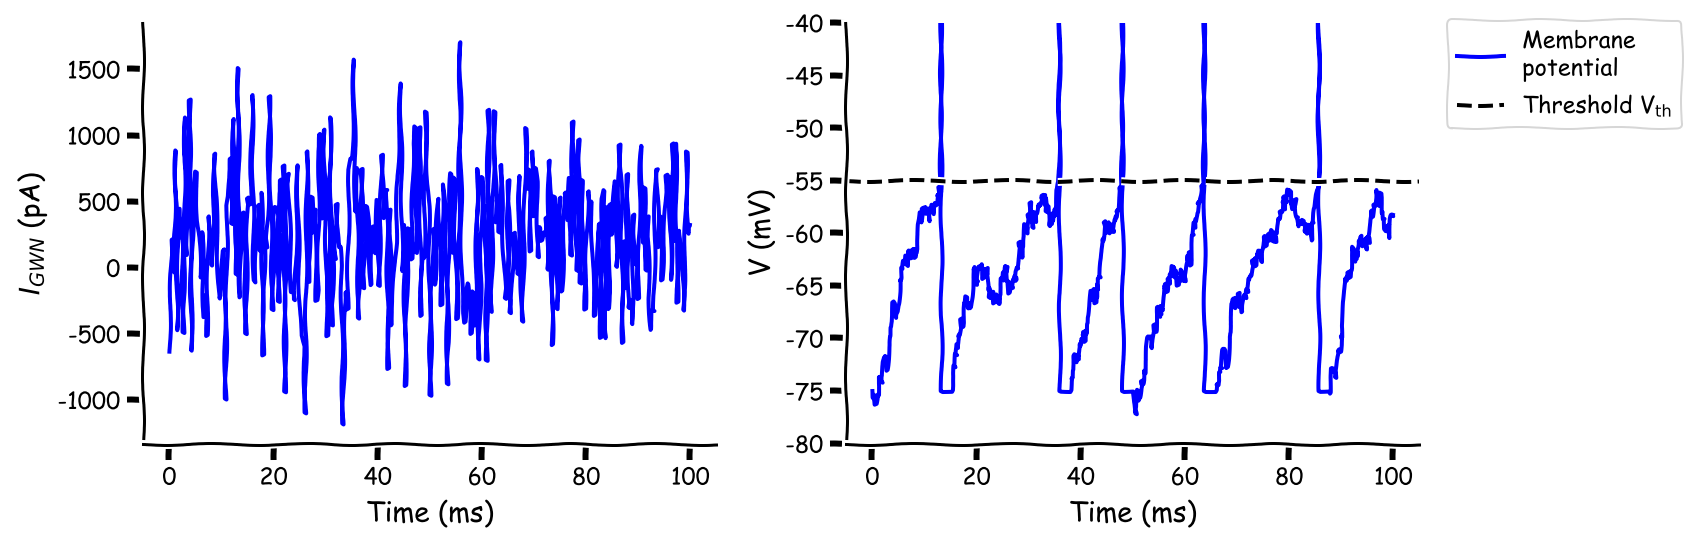

In [13]:
# to_remove solution
pars = default_pars(T=100.)
sig_gwn = 5.
mu_gwn = 250.
# Calculate the GWN current
I_GWN = my_GWN(pars, mu=mu_gwn, sig=sig_gwn, myseed=2020)
# Run the model and calculate the v and the sp
v, sp = run_LIF(pars, Iinj=I_GWN)

with plt.xkcd():
  plot_GWN(pars, I_GWN)
  plt.show()

### Interactive Demo: LIF neuron Explorer for noisy input
Here's an interactive demo that shows how the LIF neuron behavior changes for  noisy input with different amplitude and the mean $\mu$ and fluctuation $\sigma$.


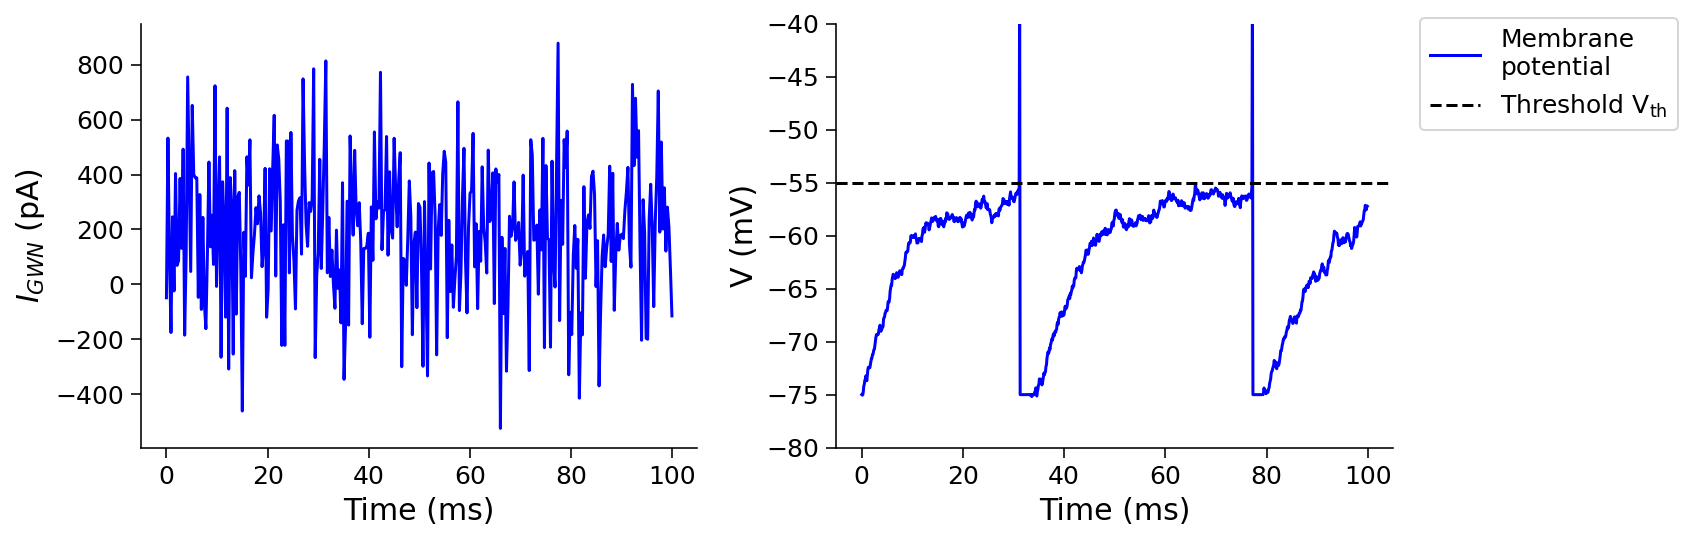

In [14]:
# @title

# @markdown Make sure you execute this cell to enable the widget!

my_layout.width = '450px'
@widgets.interact(
    mu_gwn=widgets.FloatSlider(200., min=100., max=300., step=5.,
                               layout=my_layout),
    sig_gwn=widgets.FloatSlider(2.5, min=0., max=5., step=.5,
                                layout=my_layout)
)


def diff_GWN_to_LIF(mu_gwn, sig_gwn):
  pars = default_pars(T=100.)
  I_GWN = my_GWN(pars, mu=mu_gwn, sig=sig_gwn)
  v, sp = run_LIF(pars, Iinj=I_GWN)
  plt.figure(figsize=(12, 4))
  plt.subplot(121)
  plt.plot(pars['range_t'][::3], I_GWN[::3], 'b')
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$I_{GWN}$ (pA)')
  plt.subplot(122)
  plot_volt_trace(pars, v, sp)
  plt.tight_layout()
  plt.show()

## Think!
- As we increase the input average ($\mu$) or the input fluctuation ($\sigma$), the spike count changes. How much can we increase the spike count, and what might be the relationship between GWN mean/std or DC value and spike count? 

- We have seen above that when we inject DC, the neuron spikes in a regular manner (clock like), and this regularity is reduced when GWN is injected. The question is, how irregular can we make the neurons spiking by changing the parameters of the GWN? 


---
# Section 3: Firing rate and spike time irregularity
When we plot the output firing rate as a function of GWN mean or DC value, it is called the input-output transfer function of the neuron (so simply F-I curve).

Spike regularity can be quantified as the **coefficient of variance (CV) of the inter-spike-interval (ISI)**:
\begin{align}
\text{CV}_{\text{ISI}} = \frac{std(\text{ISI})}{mean(\text{ISI})}
\end{align}

A Poisson train is an example of high irregularity, in which $\textbf{CV}_{\textbf{ISI}} \textbf{= 1}$. And for a clock like (regular) process we have $\textbf{CV}_{\textbf{ISI}} \textbf{= 0}$ because of **std(ISI)=0**.

## Interactive Demo: F-I Explorer for different `sig_gwn`
Here's an interactive demo that shows how the F-I curve of a LIF neuron changes for different levels of fluctuation $\sigma$.

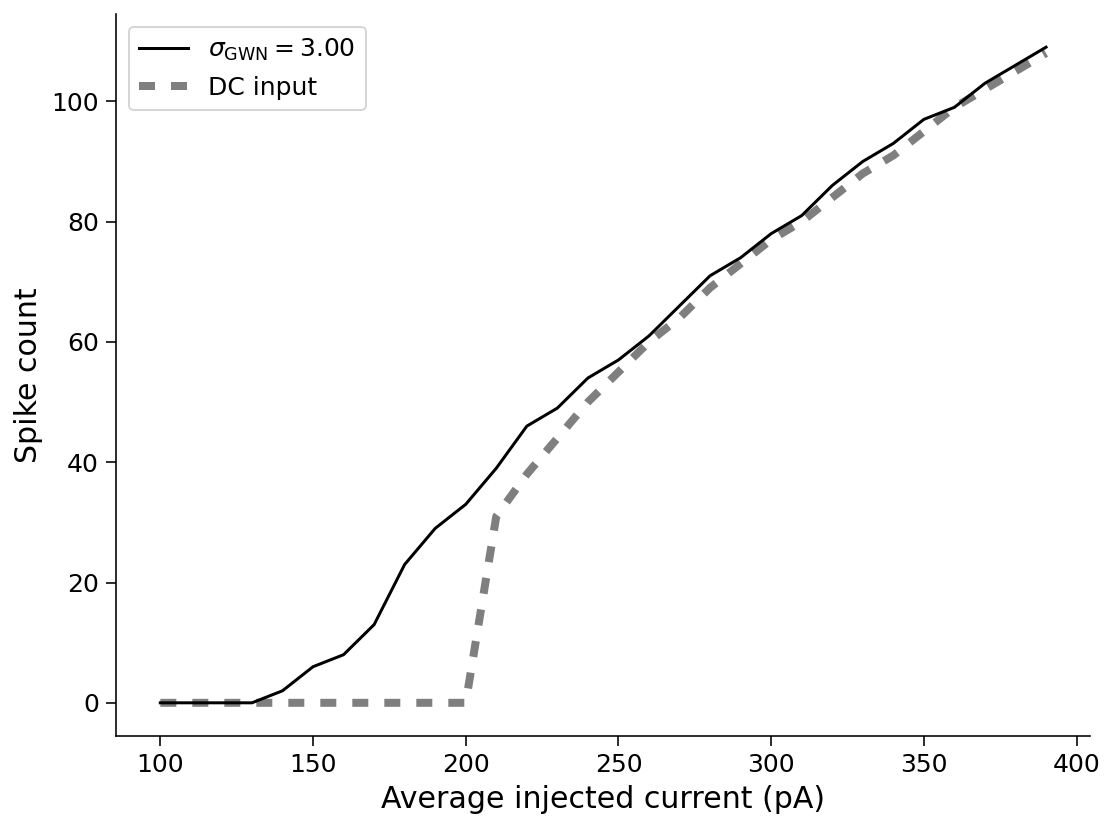

In [15]:
# @title

# @markdown Make sure you execute this cell to enable the widget!


my_layout.width = '450px'
@widgets.interact(
    sig_gwn=widgets.FloatSlider(3.0, min=0., max=6., step=0.5,
                                layout=my_layout)
)


def diff_std_affect_fI(sig_gwn):
  pars = default_pars(T=1000.)
  I_mean = np.arange(100., 400., 10.)
  spk_count = np.zeros(len(I_mean))
  spk_count_dc = np.zeros(len(I_mean))

  for idx in range(len(I_mean)):
      I_GWN = my_GWN(pars, mu=I_mean[idx], sig=sig_gwn, myseed=2020)
      v, rec_spikes = run_LIF(pars, Iinj=I_GWN)
      v_dc, rec_sp_dc = run_LIF(pars, Iinj=I_mean[idx])
      spk_count[idx] = len(rec_spikes)
      spk_count_dc[idx] = len(rec_sp_dc)

  # Plot the F-I curve i.e. Output firing rate as a function of input mean.
  plt.figure()
  plt.plot(I_mean, spk_count, 'k',
           label=r'$\sigma_{\mathrm{GWN}}=%.2f$' % sig_gwn)
  plt.plot(I_mean, spk_count_dc, 'k--', alpha=0.5, lw=4, dashes=(2, 2),
           label='DC input')
  plt.ylabel('Spike count')
  plt.xlabel('Average injected current (pA)')
  plt.legend(loc='best')
  plt.show()

### Exercise 3: Compute $CV_{ISI}$ values

As shown above, the F-I curve becomes smoother while increasing the amplitude of the fluctuation ($\sigma$). In addition, the fluctuation can also change the irregularity of the spikes. Let's investigate the effect of $\mu=250$, $\sigma=0.5$, and $\sigma=3$. 

Fill in the code below to compute ISI, then plot the histogram of the ISI and compute the $CV_{ISI}$. Note that, you can use `np.diff` to calculate ISI.

In [16]:
def isi_cv_LIF(spike_times):
  """
  Calculates the inter-spike intervals (isi) and
  the coefficient of variation (cv) for a given spike_train

  Args:
    spike_times : (n, ) vector with the spike times (ndarray)

  Returns:
    isi         : (n-1,) vector with the inter-spike intervals (ms)
    cv          : coefficient of variation of isi (float)

  """
  ########################################################################
  ## TODO for students: compute the membrane potential v, spike train sp #
  # Fill out function and remove
  raise NotImplementedError('Student Exercise: calculate the isi and the cv!')
  ########################################################################
  if len(spike_times) >= 2:
    # Compute isi
    isi = ...
    # Compute cv
    cv = ...
  else:
    isi = np.nan
    cv = np.nan

  return isi, cv


pars = default_pars(T=1000.)
mu_gwn = 250
sig_gwn1 = 0.5
sig_gwn2 = 3.0

I_GWN1 = my_GWN(pars, mu=mu_gwn, sig=sig_gwn1, myseed=2020)
_, sp1 = run_LIF(pars, Iinj=I_GWN1)

I_GWN2 = my_GWN(pars, mu=mu_gwn, sig=sig_gwn2, myseed=2020)
_, sp2 = run_LIF(pars, Iinj=I_GWN2)

# Uncomment to check your function
# isi1, cv1 = isi_cv_LIF(sp1)
# isi2, cv2 = isi_cv_LIF(sp2)

# my_hists(isi1, isi2, cv1, cv2, sig_gwn1, sig_gwn2)

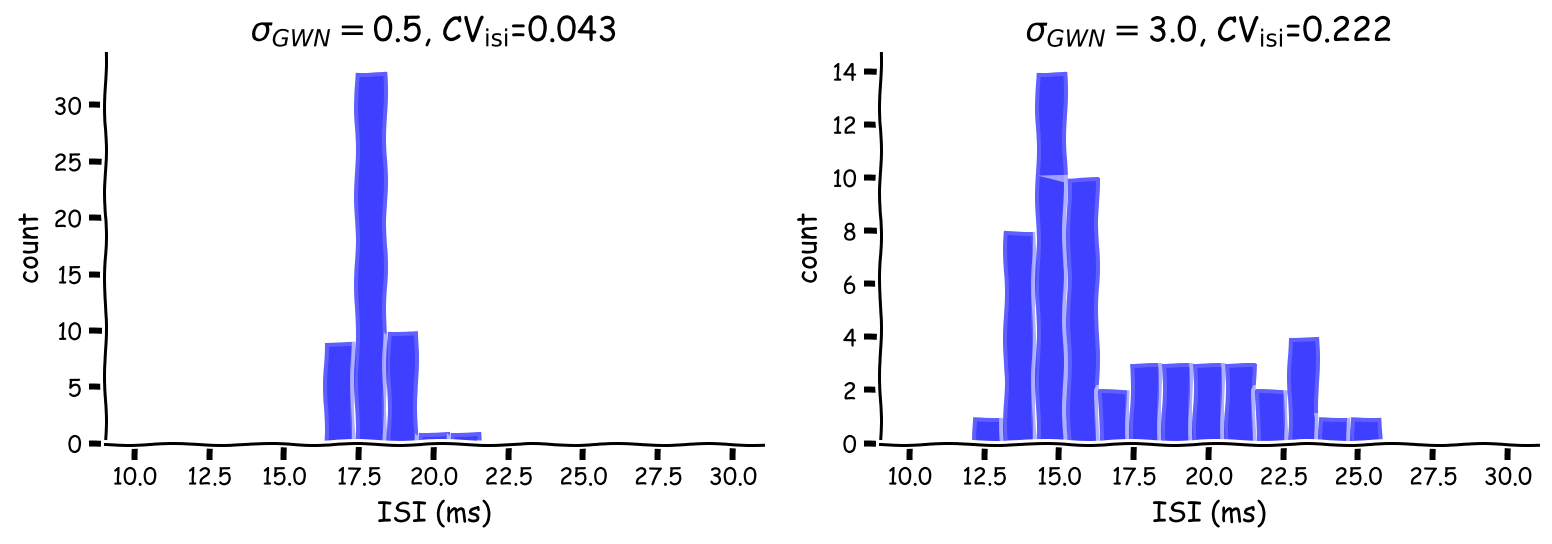

In [17]:
# to_remove solution
def isi_cv_LIF(spike_times):
  """
  Calculates the inter-spike intervals (isi) and
  the coefficient of variation (cv) for a given spike_train

  Args:
    spike_times : (n, ) vector with the spike times (ndarray)

  Returns:
    isi         : (n-1,) vector with the inter-spike intervals (ms)
    cv          : coefficient of variation of isi (float)

  """
  
  if len(spike_times) >= 2:
    # Compute isi
    isi = np.diff(spike_times)
    # Compute cv
    cv = isi.std()/isi.mean()
  else:
    isi = np.nan
    cv = np.nan

  return isi, cv


pars = default_pars(T=1000.)
mu_gwn = 250
sig_gwn1 = 0.5
sig_gwn2 = 3.0

I_GWN1 = my_GWN(pars, mu=mu_gwn, sig=sig_gwn1, myseed=2020)
_, sp1 = run_LIF(pars, Iinj=I_GWN1)

I_GWN2 = my_GWN(pars, mu=mu_gwn, sig=sig_gwn2, myseed=2020)
_, sp2 = run_LIF(pars, Iinj=I_GWN2)

# Uncomment to check your function
isi1, cv1 = isi_cv_LIF(sp1)
isi2, cv2 = isi_cv_LIF(sp2)

with plt.xkcd():
  my_hists(isi1, isi2, cv1, cv2, sig_gwn1, sig_gwn2)

## Interactive Demo: Spike irregularity explorer for different `sig_gwn`
Here's an interactive demo that shows how the function of CVs on the mean current $\mu$ changes for different levels of fluctuation $\sigma$.


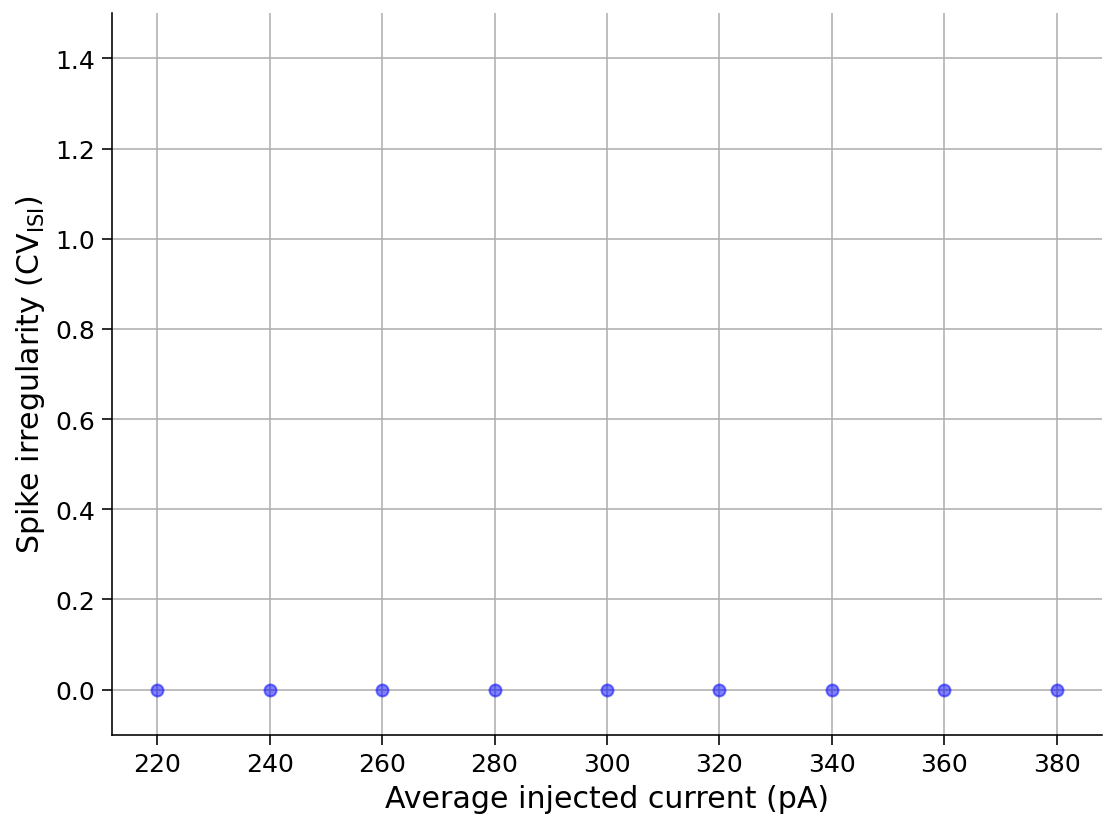

In [18]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

my_layout.width = '450px'
@widgets.interact(
    sig_gwn=widgets.FloatSlider(0.0, min=0., max=10.,
                                step=0.5, layout=my_layout)
)


def diff_std_affect_fI(sig_gwn):
  pars = default_pars(T=1000.)
  I_mean = np.arange(100., 400., 20)
  spk_count = np.zeros(len(I_mean))
  cv_isi = np.empty(len(I_mean))

  for idx in range(len(I_mean)):
    I_GWN = my_GWN(pars, mu=I_mean[idx], sig=sig_gwn)
    v, rec_spikes = run_LIF(pars, Iinj=I_GWN)
    spk_count[idx] = len(rec_spikes)
    if len(rec_spikes) > 3:
      isi = np.diff(rec_spikes)
      cv_isi[idx] = np.std(isi) / np.mean(isi)

  # Plot the F-I curve i.e. Output firing rate as a function of input mean.
  plt.figure()
  plt.plot(I_mean[spk_count > 5], cv_isi[spk_count > 5], 'bo', alpha=0.5)
  plt.xlabel('Average injected current (pA)')
  plt.ylabel(r'Spike irregularity ($\mathrm{CV}_\mathrm{ISI}$)')
  plt.ylim(-0.1, 1.5)
  plt.grid(True)
  plt.show()

### Try to answer the following:
- Does the standard deviation of the injected current affect the F-I curve in any qualitative manner?
- Why does increasing the mean of GWN reduce the $CV_{ISI}$?
- If you plot spike count (or rate) vs. $CV_{ISI}$, should there be a relationship between the two? Try out yourself.


---
# Section 4: Generation of Poisson type spike trains

*In the next tutorials, we will often use Poisson type spike train to explore properties of neurons and synapses. Therefore, it is good to know how to generate Poisson type spike trains.*

Mathematically a spike train is a Point Process. One of the simplest models of a sequence of presynaptic pulse inputs is the Poisson process. We know that given temporal integration and refractoriness, neurons cannot behave as a Poisson Process, and Gamma Process (*find out what might be the difference in the two processes*) gives a better approximation. 
Here, however, we will assume that the incoming spikes are following Poisson statistics. A question arises about how to simulate a Poisson Process. The generation of the Poisson process can be realized by at least two following ways:

- By definition, for a Poisson process with rate $\lambda$, the probability of finding one event in the time window with a sufficiently small length $\Delta t$ is $P(N = 1) = \lambda \Delta t$. Therefore, in each time window, we generate a uniformly distributed random variable $r \in [0,1]$ and generate a Poisson event when $r <\lambda \Delta t$. This method allows us to generate Poisson distributed spikes in an online manner.


- The interval $t_{k+1}-t_{k}$ between two Poisson events with rate $\lambda$ follows the exponential distribution, i.e., $P(t_{k+1}-t_{k}<t) = 1 - e^{\lambda t}$. Therefore, we only need to generate a set of exponentially distributed variables $\{s_k\}$ to obtain the timing of Poisson events $t_{k+1}=t_{k}+s_{k}$. In this method, we need to generate all future spikes at once. 

Below we use the first method and check the statistical property of the time interval between two Poisson events.

## Function to generate Poisson spike trains

In [19]:
# @title `Poisson_generator(pars, rate, n, myseed`)
# @markdown Make sure you execute this cell to create Poisson spikes!


def Poisson_generator(pars, rate, n, myseed=False):
  """
  Generates poisson trains

  Args:
    pars            : parameter dictionary
    rate            : noise amplitute [Hz]
    n               : number of Poisson trains
    myseed          : random seed. int or boolean

  Returns:
    pre_spike_train : spike train matrix, ith row represents whether
                      there is a spike in ith spike train over time
                      (1 if spike, 0 otherwise)
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate uniformly distributed random variables
  u_rand = np.random.rand(n, Lt)

  # generate Poisson train
  poisson_train = 1. * (u_rand < rate * (dt / 1000.))

  return poisson_train


# the function plot the raster of the Poisson spike train
def my_raster_Poisson(range_t, spike_train, n):
  """
  Generates poisson trains

  Args:
    range_t     : time sequence
    spike_train : binary spike trains, with shape (N, Lt)
    n           : number of Poisson trains plot

  Returns:
    Raster plot of the spike train
  """

  # find the number of all the spike trains
  N = spike_train.shape[0]

  # n should smaller than N:
  if n > N:
    print('The number n exceeds the size of spike trains')
    print('The number n is set to be the size of spike trains')
    n = N

  # plot rater
  i = 0
  while i < n:
    if spike_train[i, :].sum() > 0.:
      t_sp = range_t[spike_train[i, :] > 0.5]  # spike times
      plt.plot(t_sp, i * np.ones(len(t_sp)), 'k|', ms=10, markeredgewidth=2)
    i += 1
  plt.xlim([range_t[0], range_t[-1]])
  plt.ylim([-0.5, n + 0.5])
  plt.xlabel('Time (ms)', fontsize=12)
  plt.ylabel('Neuron ID', fontsize=12)

Help on function my_raster_Poisson in module __main__:

my_raster_Poisson(range_t, spike_train, n)
    Generates poisson trains
    
    Args:
      range_t     : time sequence
      spike_train : binary spike trains, with shape (N, Lt)
      n           : number of Poisson trains plot
    
    Returns:
      Raster plot of the spike train

None


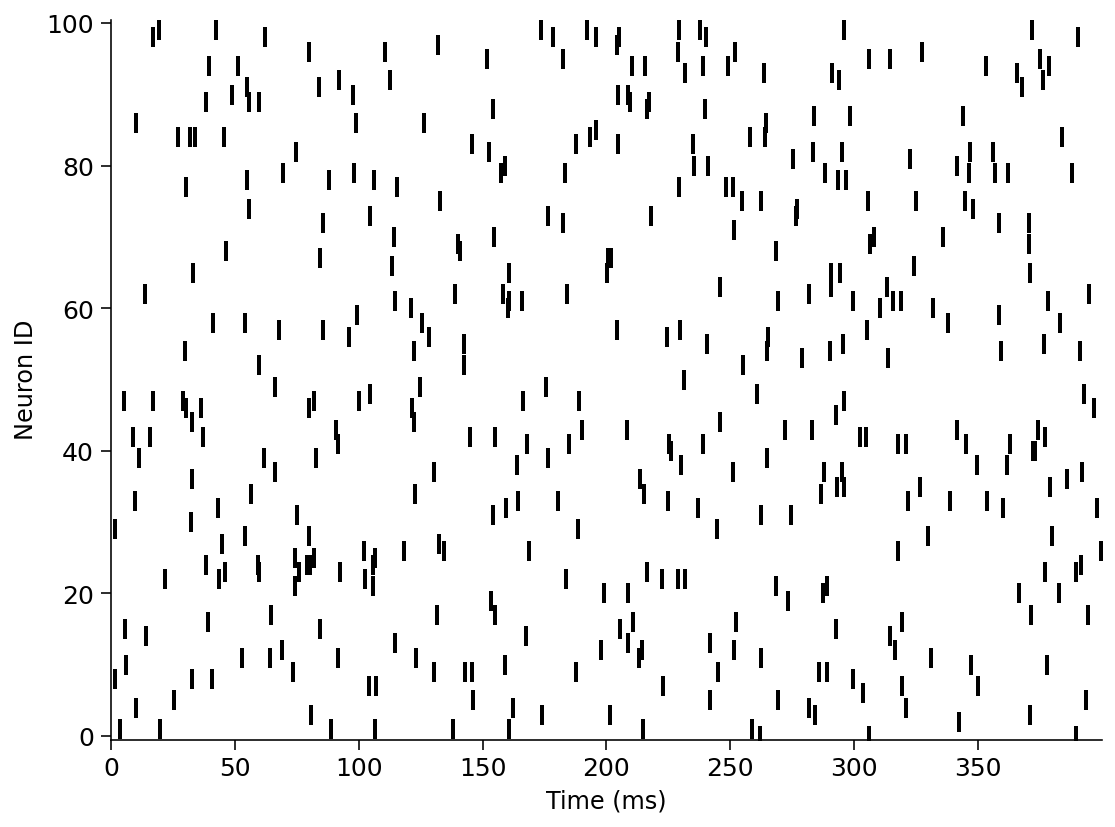

In [20]:
# we can use Poisson_generator to mimic presynaptic spike trains
pars = default_pars()
pre_spike_train = Poisson_generator(pars, rate=10, n=100, myseed=2020)
my_raster_Poisson(pars['range_t'], pre_spike_train, 100)

print(help(my_raster_Poisson))  # use `help` to learn about the function

How do we make sure that the above spike trains are following Poisson statistics?
A Poisson process must have the following properties:
- The ratio of the mean and variance of spike count is 1
- Inter-spike-intervals are exponentially distributed
- Spike times are irregular i.e. $CV_{\rm ISI} = 1$
- Adjacent spike intervals are independent of each other.


---
# Summary

Congratulations! You've just built a leaky integrate-and-fire (LIF) neuron model from scratch, and studied its dynamics in response to various types of inputs, having:

- simulated the LIF neuron model

- driven the LIF neuron with external inputs, such as DC current, Gaussian white noise, and Poisson spike trains, etc.

- studied how different inputs affect the  LIF neuron's output (firing rate and spike time irregularity),

with a special focus on low rate and irregular firing regime to mimc real cortical neurons. The next tutorial will look at how spiking statistics may be influenced by a neuron's input statistics.

However, if you have extra time, follow the section below to explore a different type of noise input.


---
# Bonus 1: Orenstein-Uhlenbeck Process

When a neuron received spiking input, the synaptic current is Shot Noise -- which is a kind of colored noise and the spectrum of the noise determined by the synaptic kernel time constant. That is, a neuron is driven by **colored noise** and not GWN.

We can model colored noise using the Ohrenstein-Uhlenbeck process - filtered white noise. 

## Ornstein-Uhlenbeck (OU) current

We next study if the input current is temporally correlated and is modeled as an Ornstein-Uhlenbeck process $\eta(t)$, i.e., low-pass filtered GWN with a time constant $\tau_{\eta}$: 

$$\tau_\eta \frac{d}{dt}\eta(t) = \mu-\eta(t) + \sigma_\eta\sqrt{2\tau_\eta}\xi(t).$$

**Hint:** An OU process as defined above has

$$E[\eta(t)]=\mu$$ 

and autocovariance 

$$[\eta(t)\eta(t+\tau)]=\sigma_\eta^2e^{-|t-\tau|/\tau_\eta},$$

which can be used to check your code. 

In [21]:
# @title `my_OU(pars, mu, sig, myseed)`
# @markdown Ececute this cell to enable the OU process


def my_OU(pars, mu, sig, myseed=False):
  """
  Function that produces Ornstein-Uhlenbeck input

  Args:
    pars       : parameter dictionary
    sig        : noise amplitute
    myseed     : random seed. int or boolean

  Returns:
    I_ou       : Ornstein-Uhlenbeck input current
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tau_ou = pars['tau_ou']  # [ms]

  # set random seed
  if myseed:
    np.random.seed(seed=myseed)
  else:
    np.random.seed()

  # Initialize
  noise = np.random.randn(Lt)
  I_ou = np.zeros(Lt)
  I_ou[0] = noise[0] * sig

  # generate OU
  for it in range(Lt-1):
    I_ou[it+1] = I_ou[it] + (dt / tau_ou) * (mu - I_ou[it]) + np.sqrt(2 * dt / tau_ou) * sig * noise[it + 1]

  return I_ou

### Interactive Demo: LIF Explorer with OU input
In the following, we will check how a neuron responds to a noisy current that follows the statistics of an OU process.

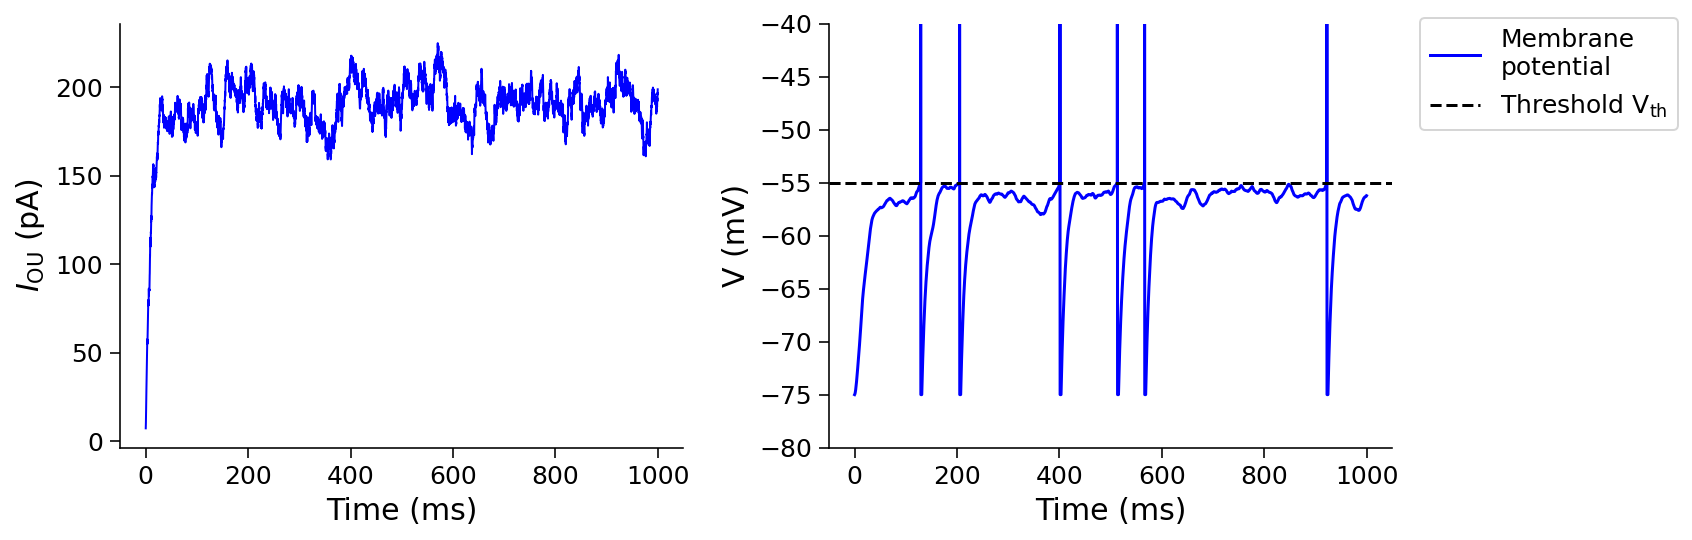

In [22]:
# @title

# @markdown Remember to enable the widget by running the cell!

my_layout.width = '450px'
@widgets.interact(
  tau_ou=widgets.FloatSlider(10.0, min=5., max=20.,
                             step=2.5, layout=my_layout),
  sig_ou=widgets.FloatSlider(10.0, min=5., max=40.,
                             step=2.5, layout=my_layout),
  mu_ou=widgets.FloatSlider(190.0, min=180., max=220.,
                            step=2.5, layout=my_layout)
)


def LIF_with_OU(tau_ou=10., sig_ou=40., mu_ou=200.):
  pars = default_pars(T=1000.)
  pars['tau_ou'] = tau_ou  # [ms]

  I_ou = my_OU(pars, mu_ou, sig_ou)

  v, sp = run_LIF(pars, Iinj=I_ou)

  plt.figure(figsize=(12, 4))
  plt.subplot(121)
  plt.plot(pars['range_t'], I_ou, 'b', lw=1.0)
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$I_{\mathrm{OU}}$ (pA)')
  plt.subplot(122)
  plot_volt_trace(pars, v, sp)
  plt.tight_layout()
  plt.show()

## Think!
- How does the OU type input change neuron responsiveness? 
- What do you think will happen to the spike pattern and rate if you increased or decreased the time constant of the OU process?

---
# Bonus 2: Generalized Integrate-and-Fire models

LIF model is not the only abstraction of real neurons. If you want to learn about more realistic types of neuronal models, watch the Bonus Video!

Video available at https://youtube.com/watch?v=G0b6wLhuQxE


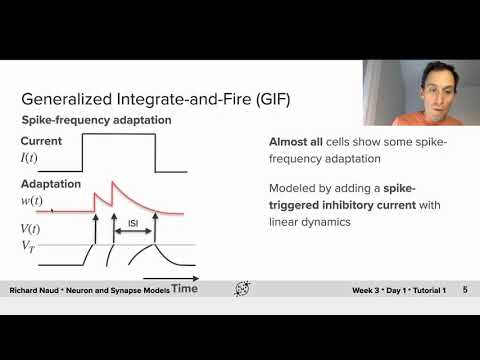

In [23]:
#@title Video 3 (Bonus): Extensions to Integrate-and-Fire models
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='G0b6wLhuQxE', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video